In [58]:
# import needed libaries

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from keras.backend import clear_session
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Softmax, BatchNormalization, Input, Dropout

%matplotlib inline

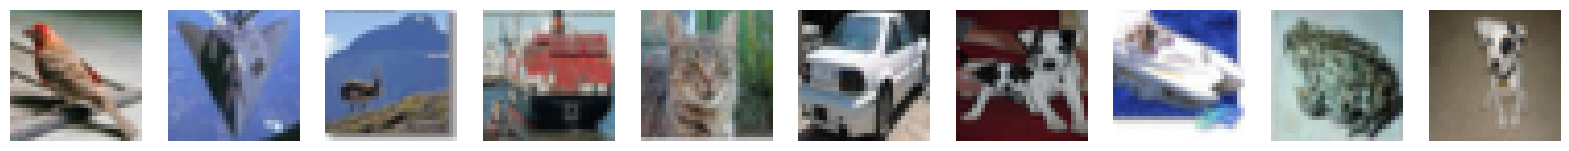

In [17]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images by scaling the pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class labels (y_train, y_test) to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Plot a few random images from the training set
def plot_random_images():
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        random_idx = np.random.randint(0, len(x_train))
        axes[i].imshow(x_train[random_idx])
        axes[i].axis('off')
    plt.show()

# Call the function to display random images
plot_random_images()

### Add reusable methods for plotting confusion matrix / comparison of accuracy and loss

In [65]:
# The confusion matrix shows the counts of true positives, true negatives, false positives, and false negatives for each class, revealing how well the model predicts different classes.

def show_confusion_matrix(cnn_model, y_test_data, x_test_data, name):
    predictions = cnn_model.predict(x_test_data)
    predictions = np.argmax(predictions, axis=1)
    gt = np.argmax(y_test_data, axis=1)
    
    cm = metrics.confusion_matrix(gt, predictions)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f"output/confusion_matrix_{name}.png")
    plt.show()

In [67]:
def show_compare_graph(cnn_history, name):
    plt.title('Loss / Accuracy')
    plt.plot(cnn_history.history['loss'], color='red', label='train')
    plt.plot(cnn_history.history['accuracy'], color='green', label='train')
    plt.savefig(f"output/compare_graph_{name}.png")
    plt.show()

In [50]:
# function to get the F-1 score
def show_classification_report(cnn_model, y_test_data, x_test_data):
    predictions = cnn_model.predict(x_test_data)
    predictions = np.argmax(predictions, axis=1)
    print(metrics.classification_report(y_test_data, predictions))

### Define first model with 60 epochs and a batch size of 512

In [22]:
clear_session()

In [24]:
# Define the CNN model
model = Sequential()

# Add a convolutional layer with a 3x3 filter, 32 filters, and input shape (32, 32, 3)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add a dense layer with 100 units
model.add(Dense(100, activation='relu'))

# Add the output classification layer with softmax activation for 10 classes
model.add(Dense(10, activation='softmax'))

# Print model summary
model.summary()

In [29]:
# Compile model 
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=60, batch_size=512, validation_data=(x_test, y_test))

end_time = time.time()

# Calculate the time taken
training_time = end_time - start_time

print(f"Model training time: {training_time} seconds")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


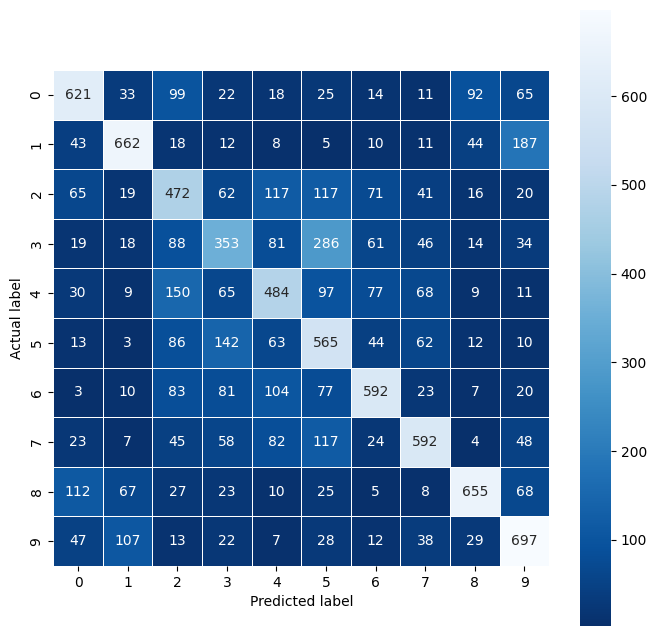

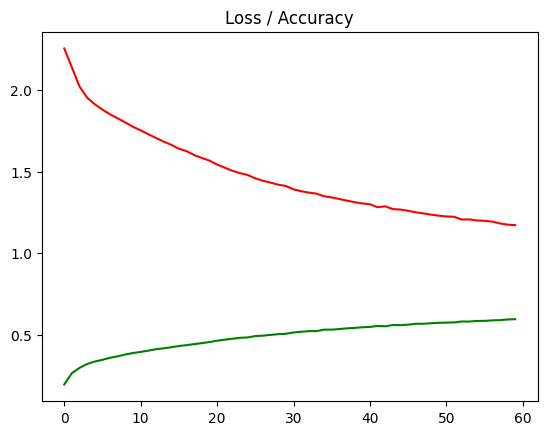

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [74]:
show_confusion_matrix(model, y_test, x_test, 'model_1')
show_compare_graph(history, 'model_1')
show_classification_report(model, y_test, x_test)

As we can see, the result is not very good. The loss is higher as the accuracy

In [73]:
# Define the CNN model
model2 = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])